<center>
    <h1><b>Phân Tích và Dự Đoán Trạng Thái Tâm Lý Qua Miêu Tả Dạng Văn Bản</b></h1>
    <h2><b>Học phần: Học máy</b></h2>
    <h3><b>Giảng viên: TS. Cao Văn Chung</b></h3>
</center>

---
**Sinh viên thực hiện:**
- Trần Anh Minh - 21000242
- Dương Đức Vương - 22000133
- Nguyễn Tuấn Kiệt - 22000100

## Tiền xử lý dữ liệu

In [8]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as mp
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re as r
from nltk.stem import PorterStemmer

#Tải dữ liệu và tiền xử lý dữ liệu
df=pd.read_csv("New Data.csv")
df.drop('Unnamed: 0',axis=1,inplace=True)
df.dropna(inplace=True)

# Lấy ngẫu nhiên 20.000 dòng từ dữ liệu ban đầu
df = df.sample(n=20000, random_state=42).reset_index(drop=True)

max_count=df['status'].value_counts().max()

def resample_data(df):
    max_count = df['status'].value_counts().max()

    df_resampled = pd.DataFrame()

    for status in df['status'].unique():
        df_class = df[df['status'] == status]
        if len(df_class) < max_count:
            df_class_resampled = resample(df_class,
                                          replace=True,
                                          n_samples=max_count,
                                          random_state=42)
            df_resampled = pd.concat([df_resampled, df_class_resampled])
        else:
            df_resampled = pd.concat([df_resampled, df_class])

    return df_resampled


df = resample_data(df)
pt=PorterStemmer()

def preprocessing(x):
    l=[]

    text = r.sub(r'[^a-zA-Z0-9\s]', '', x.lower())
    for i in text.split():
        l.append(pt.stem(i.lower()))


    return " ".join(l)
df['statement']=df['statement'].apply(preprocessing)

x=df['statement']
y=df['status']

x_train1,x_test1,y_train1,y_test1=train_test_split(x,y,random_state=42,test_size=0.2)
x_train2,x_test2,y_train2,y_test2=train_test_split(x,y,random_state=42,test_size=0.3)
x_train3,x_test3,y_train3,y_test3=train_test_split(x,y,random_state=42,test_size=0.4)


## Vector hóa tập các tập train/ test bằng TF-TDF

In [9]:
# TF-IDF từng tập train, test
vec1 = TfidfVectorizer(max_features=10000)
x_train_tfidf1 = vec1.fit_transform(x_train1)
x_test_tfidf1 = vec1.transform(x_test1)

vec2 = TfidfVectorizer(max_features=10000)
x_train_tfidf2 = vec2.fit_transform(x_train2)
x_test_tfidf2 = vec2.transform(x_test2)

vec3 = TfidfVectorizer(max_features=10000)
x_train_tfidf3 = vec3.fit_transform(x_train3)
x_test_tfidf3 = vec3.transform(x_test3)

# Số chiều từng tập train/test
print("Tập train 1 (4:1):")
print("Số chiều tập train:", x_train_tfidf1.shape)
print("Số chiều tập test:", x_test_tfidf1.shape)

print("Tập train 2 (7:3):")
print("Số chiều tập train:", x_train_tfidf2.shape)
print("Số chiều tập test:", x_test_tfidf2.shape)

print("Tập train 3 (6:4):")
print("Số chiều tập train:", x_train_tfidf3.shape)
print("Số chiều tập test:", x_test_tfidf3.shape)


Tập train 1 (4:1):
Số chiều tập train: (47313, 10000)
Số chiều tập test: (11829, 10000)
Tập train 2 (7:3):
Số chiều tập train: (41399, 10000)
Số chiều tập test: (17743, 10000)
Tập train 3 (6:4):
Số chiều tập train: (35485, 10000)
Số chiều tập test: (23657, 10000)


## MULTI LAYER PERCEPTRON

### Dùng PyTorch

* Định nghĩa model ANN và hàm huấn luyện/đánh giá

In [6]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Mạng ANN có 2 tầng ẩn và dropou
class ANN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1  = nn.Linear(input_dim, 128)    # Tầng ẩn duy nhất
        self.drop = nn.Dropout(0.5)              # Dropout giúp chống overfitting
        self.out  = nn.Linear(128, num_classes)  # Tầng đầu ra

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        return self.out(x)


# Huấn luyện và đánh giá
def train_evaluate_ANN_pytorch(x_train_tfidf, x_test_tfidf,
                               y_train_enc,   y_test_enc,
                               label_encoder, description=""):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_tr = torch.tensor(x_train_tfidf.toarray(), dtype=torch.float32)
    X_te = torch.tensor(x_test_tfidf.toarray(),  dtype=torch.float32)
    y_tr = torch.tensor(y_train_enc, dtype=torch.long)
    y_te = torch.tensor(y_test_enc, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=64, shuffle=True)
    val_loader   = DataLoader(TensorDataset(X_te, y_te), batch_size=64)

    model     = ANN(X_tr.shape[1], len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    train_losses, val_losses = [], []
    train_accs, val_accs     = [], []

    best_val_loss = float('inf')
    patience = 5
    counter = 0
    best_model_state = None

    epochs = 30
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out   = model(X)
            loss  = criterion(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total   += y.size(0)

        train_losses.append(total_loss / len(train_loader))
        train_accs.append(correct / total)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                out = model(X)
                loss = criterion(out, y)
                val_loss += loss.item()

                preds = out.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y.cpu().numpy())

        val_acc = accuracy_score(all_labels, all_preds)
        val_accs.append(val_acc)
        val_losses.append(val_loss / len(val_loader))

        print(f"[{description}] Epoch {epoch:02}/{epochs} | "
              f"Train Loss {train_losses[-1]:.4f} | "
              f"Train Acc {train_accs[-1]:.4f} | "
              f"Val Loss {val_losses[-1]:.4f} | Val Acc {val_acc:.4f}")

        # Early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            counter = 0
            best_model_state = model.state_dict()
        else:
            counter += 1
            if counter >= patience:
                print(f">>> Early stopping tại epoch {epoch}")
                break

    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Vẽ đồ thị
    plt.figure()
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train loss")
    plt.plot(range(1, len(val_losses)+1), val_losses,   label="Val loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title(f"Loss – {description}")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(range(1, len(train_accs)+1), train_accs, label="Train acc")
    plt.plot(range(1, len(val_accs)+1), val_accs,     label="Val acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.title(f"Accuracy – {description}")
    plt.legend()
    plt.show()

    # Đánh giá
    model.eval()
    with torch.no_grad():
        preds = model(X_te.to(device)).argmax(dim=1).cpu().numpy()
    y_pred_labels  = label_encoder.inverse_transform(preds)
    y_true_labels  = label_encoder.inverse_transform(y_test_enc)

    print(f"\n===== Đánh giá mô hình cho {description} =====")
    print("Độ chính xác (Accuracy):", accuracy_score(y_true_labels, y_pred_labels))
    print("Báo cáo phân loại (Classification Report):")
    print(classification_report(y_true_labels, y_pred_labels))
    print("\nMa trận nhầm lẫn:")
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix – {description}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


* Mã hóa nhãn

In [10]:

from sklearn.preprocessing import LabelEncoder

le1 = LabelEncoder()
y_train1_enc = le1.fit_transform(y_train1)
y_test1_enc = le1.transform(y_test1)

le2 = LabelEncoder()
y_train2_enc = le2.fit_transform(y_train2)
y_test2_enc = le2.transform(y_test2)

le3 = LabelEncoder()
y_train3_enc = le3.fit_transform(y_train3)
y_test3_enc = le3.transform(y_test3)


* Gọi hàm huấn luyện/đánh giá:

[Tập 1 (train:test = 4:1)] Epoch 01/30 | Train Loss 0.7077 | Train Acc 0.8179 | Val Loss 0.2326 | Val Acc 0.9445
[Tập 1 (train:test = 4:1)] Epoch 02/30 | Train Loss 0.1754 | Train Acc 0.9582 | Val Loss 0.1223 | Val Acc 0.9686
[Tập 1 (train:test = 4:1)] Epoch 03/30 | Train Loss 0.0972 | Train Acc 0.9781 | Val Loss 0.0908 | Val Acc 0.9759
[Tập 1 (train:test = 4:1)] Epoch 04/30 | Train Loss 0.0656 | Train Acc 0.9850 | Val Loss 0.0788 | Val Acc 0.9786
[Tập 1 (train:test = 4:1)] Epoch 05/30 | Train Loss 0.0473 | Train Acc 0.9903 | Val Loss 0.0722 | Val Acc 0.9796
[Tập 1 (train:test = 4:1)] Epoch 06/30 | Train Loss 0.0359 | Train Acc 0.9929 | Val Loss 0.0720 | Val Acc 0.9801
[Tập 1 (train:test = 4:1)] Epoch 07/30 | Train Loss 0.0294 | Train Acc 0.9943 | Val Loss 0.0697 | Val Acc 0.9810
[Tập 1 (train:test = 4:1)] Epoch 08/30 | Train Loss 0.0248 | Train Acc 0.9956 | Val Loss 0.0724 | Val Acc 0.9801
[Tập 1 (train:test = 4:1)] Epoch 09/30 | Train Loss 0.0214 | Train Acc 0.9962 | Val Loss 0.0740 

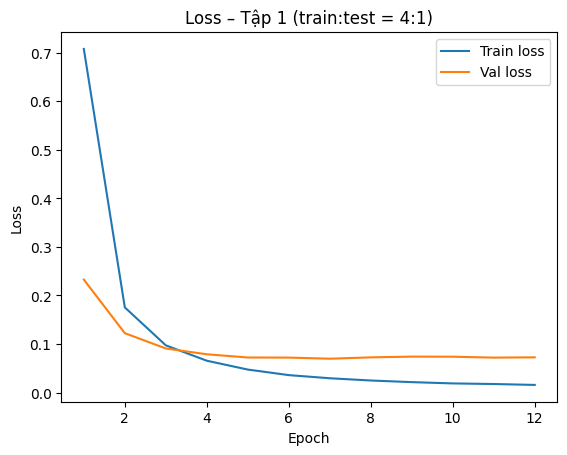

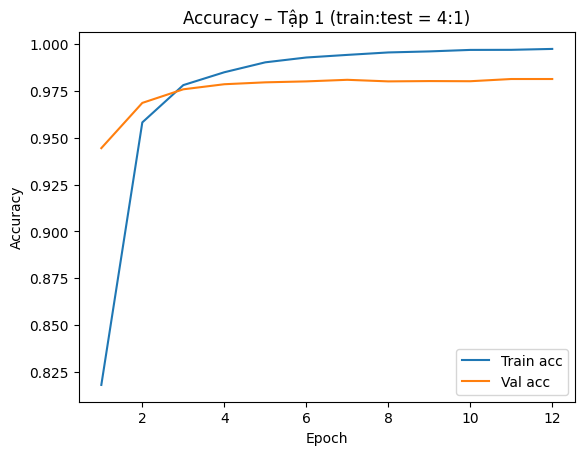


===== Đánh giá mô hình cho Tập 1 (train:test = 4:1) =====
Độ chính xác (Accuracy): 0.9814016400371968
Báo cáo phân loại (Classification Report):
                      precision    recall  f1-score   support

             Anxiety       0.98      1.00      0.99      2012
             Bipolar       0.99      1.00      1.00      1901
          Depression       0.98      0.91      0.95      1934
              Normal       0.95      0.98      0.97      2001
Personality disorder       0.99      1.00      1.00      1990
              Stress       0.98      1.00      0.99      1991

            accuracy                           0.98     11829
           macro avg       0.98      0.98      0.98     11829
        weighted avg       0.98      0.98      0.98     11829


Ma trận nhầm lẫn:
[[2007    0    1    0    2    2]
 [   0 1901    0    0    0    0]
 [  28    9 1766   93    9   29]
 [   5    1   33 1954    0    8]
 [   0    0    0    0 1990    0]
 [   0    0    0    0    0 1991]]


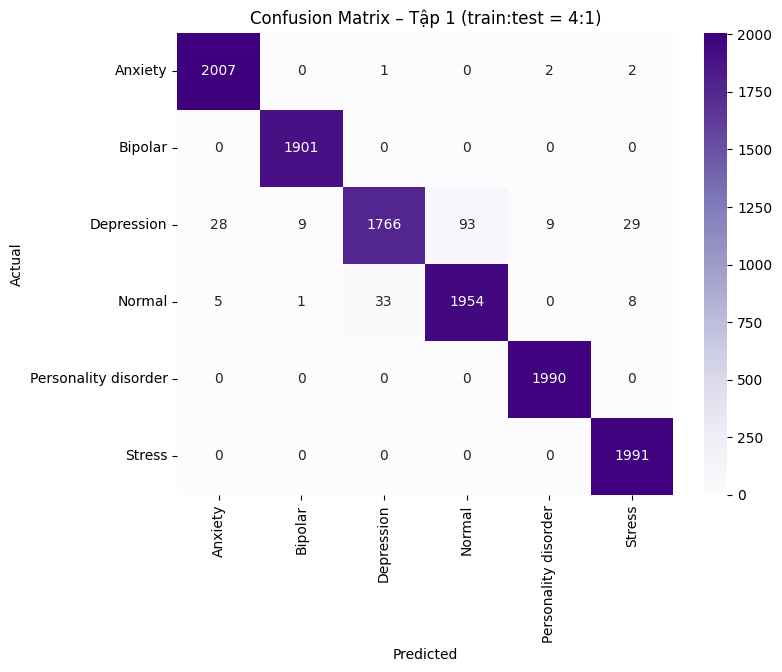

[Tập 2 (train:test = 7:3)] Epoch 01/30 | Train Loss 0.7632 | Train Acc 0.8079 | Val Loss 0.2642 | Val Acc 0.9345
[Tập 2 (train:test = 7:3)] Epoch 02/30 | Train Loss 0.1967 | Train Acc 0.9521 | Val Loss 0.1407 | Val Acc 0.9639
[Tập 2 (train:test = 7:3)] Epoch 03/30 | Train Loss 0.1078 | Train Acc 0.9759 | Val Loss 0.1018 | Val Acc 0.9720
[Tập 2 (train:test = 7:3)] Epoch 04/30 | Train Loss 0.0711 | Train Acc 0.9848 | Val Loss 0.0849 | Val Acc 0.9770
[Tập 2 (train:test = 7:3)] Epoch 05/30 | Train Loss 0.0519 | Train Acc 0.9893 | Val Loss 0.0789 | Val Acc 0.9784
[Tập 2 (train:test = 7:3)] Epoch 06/30 | Train Loss 0.0392 | Train Acc 0.9923 | Val Loss 0.0762 | Val Acc 0.9784
[Tập 2 (train:test = 7:3)] Epoch 07/30 | Train Loss 0.0313 | Train Acc 0.9941 | Val Loss 0.0761 | Val Acc 0.9790
[Tập 2 (train:test = 7:3)] Epoch 08/30 | Train Loss 0.0261 | Train Acc 0.9957 | Val Loss 0.0762 | Val Acc 0.9796
[Tập 2 (train:test = 7:3)] Epoch 09/30 | Train Loss 0.0223 | Train Acc 0.9963 | Val Loss 0.0763 

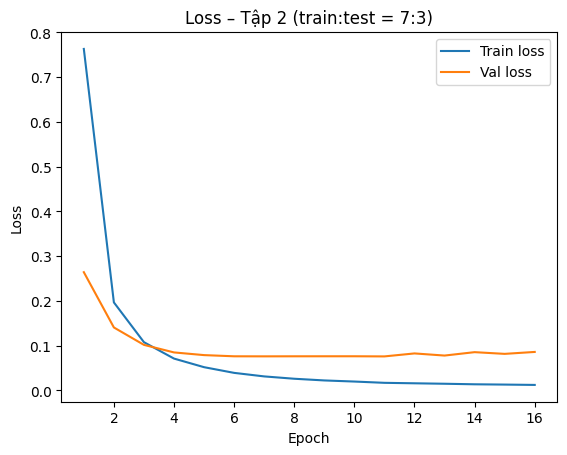

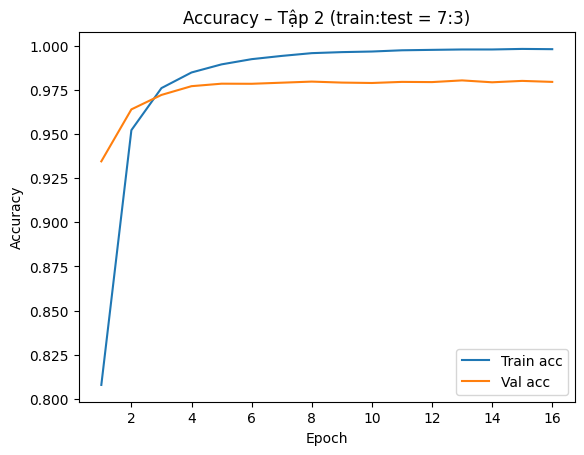


===== Đánh giá mô hình cho Tập 2 (train:test = 7:3) =====
Độ chính xác (Accuracy): 0.9794285070168517
Báo cáo phân loại (Classification Report):
                      precision    recall  f1-score   support

             Anxiety       0.98      1.00      0.99      3015
             Bipolar       0.99      1.00      0.99      2914
          Depression       0.98      0.91      0.94      2890
              Normal       0.95      0.97      0.96      3031
Personality disorder       0.99      1.00      1.00      2925
              Stress       0.98      1.00      0.99      2968

            accuracy                           0.98     17743
           macro avg       0.98      0.98      0.98     17743
        weighted avg       0.98      0.98      0.98     17743


Ma trận nhầm lẫn:
[[3012    0    1    0    2    0]
 [   0 2907    7    0    0    0]
 [  41   26 2631  140   13   39]
 [  23    4   47 2935    2   20]
 [   0    0    0    0 2925    0]
 [   0    0    0    0    0 2968]]


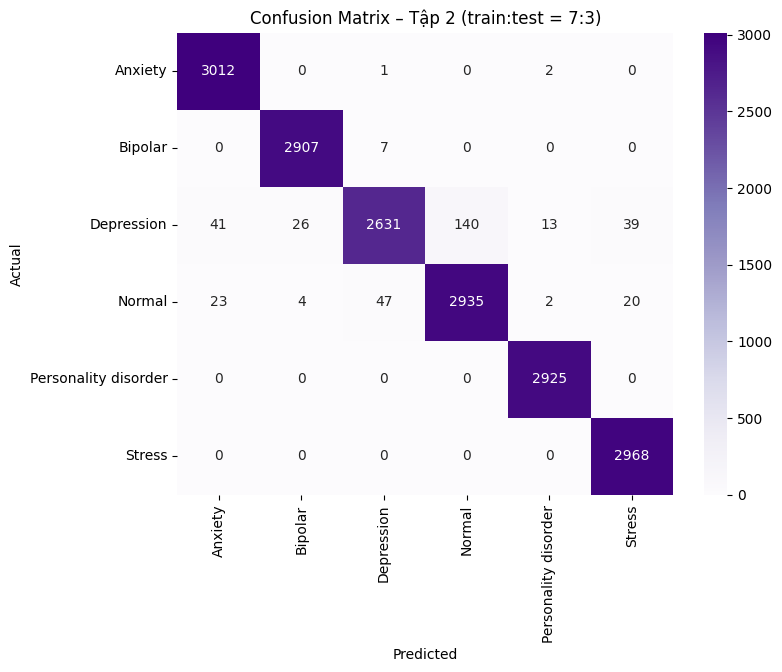

[Tập 3 (train:test = 6:4)] Epoch 01/30 | Train Loss 0.8473 | Train Acc 0.7831 | Val Loss 0.3160 | Val Acc 0.9199
[Tập 3 (train:test = 6:4)] Epoch 02/30 | Train Loss 0.2333 | Train Acc 0.9424 | Val Loss 0.1639 | Val Acc 0.9597
[Tập 3 (train:test = 6:4)] Epoch 03/30 | Train Loss 0.1291 | Train Acc 0.9713 | Val Loss 0.1173 | Val Acc 0.9685
[Tập 3 (train:test = 6:4)] Epoch 04/30 | Train Loss 0.0848 | Train Acc 0.9813 | Val Loss 0.0953 | Val Acc 0.9749
[Tập 3 (train:test = 6:4)] Epoch 05/30 | Train Loss 0.0596 | Train Acc 0.9876 | Val Loss 0.0871 | Val Acc 0.9749
[Tập 3 (train:test = 6:4)] Epoch 06/30 | Train Loss 0.0468 | Train Acc 0.9909 | Val Loss 0.0835 | Val Acc 0.9760
[Tập 3 (train:test = 6:4)] Epoch 07/30 | Train Loss 0.0358 | Train Acc 0.9934 | Val Loss 0.0806 | Val Acc 0.9779
[Tập 3 (train:test = 6:4)] Epoch 08/30 | Train Loss 0.0294 | Train Acc 0.9950 | Val Loss 0.0816 | Val Acc 0.9771
[Tập 3 (train:test = 6:4)] Epoch 09/30 | Train Loss 0.0243 | Train Acc 0.9961 | Val Loss 0.0835 

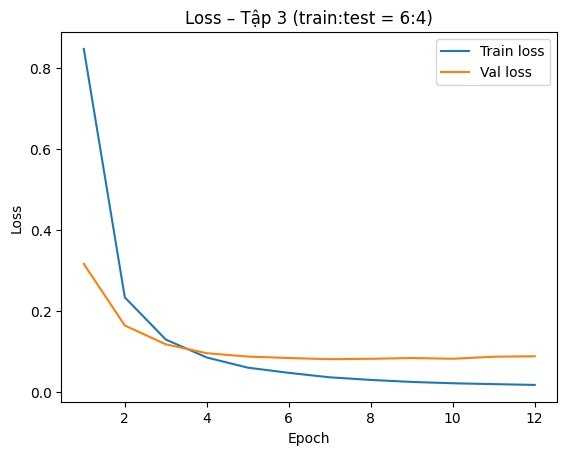

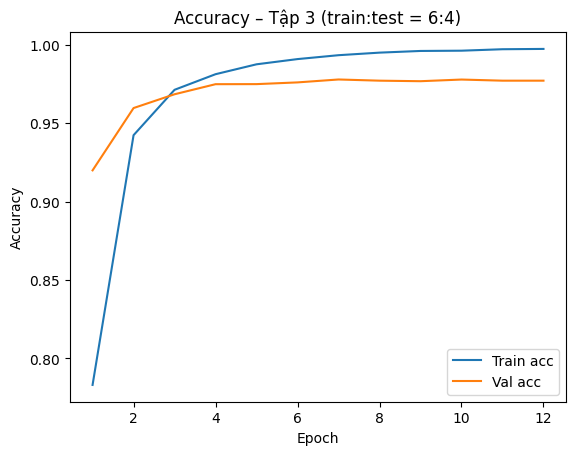


===== Đánh giá mô hình cho Tập 3 (train:test = 6:4) =====
Độ chính xác (Accuracy): 0.9771315044172972
Báo cáo phân loại (Classification Report):
                      precision    recall  f1-score   support

             Anxiety       0.98      1.00      0.99      3974
             Bipolar       0.99      1.00      0.99      3925
          Depression       0.98      0.90      0.94      3867
              Normal       0.95      0.96      0.96      4018
Personality disorder       0.99      1.00      1.00      3897
              Stress       0.98      1.00      0.99      3976

            accuracy                           0.98     23657
           macro avg       0.98      0.98      0.98     23657
        weighted avg       0.98      0.98      0.98     23657


Ma trận nhầm lẫn:
[[3961    1    3    3    2    4]
 [   0 3918    4    3    0    0]
 [  48   47 3494  200   18   60]
 [  35    7   79 3870    3   24]
 [   0    0    0    0 3897    0]
 [   0    0    0    0    0 3976]]


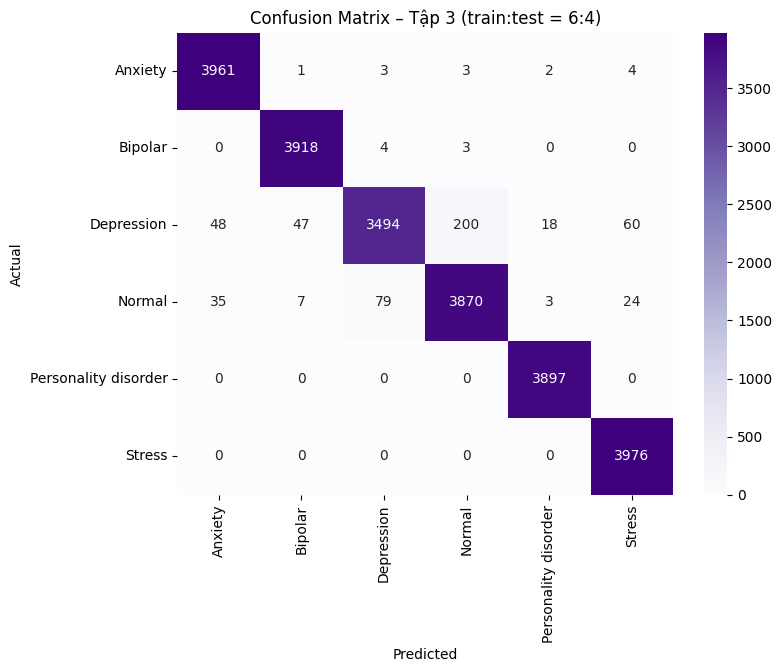

In [11]:
train_evaluate_ANN_pytorch(x_train_tfidf1, x_test_tfidf1, y_train1_enc, y_test1_enc,
                           le1, description="Tập 1 (train:test = 4:1)")
train_evaluate_ANN_pytorch(x_train_tfidf2, x_test_tfidf2, y_train2_enc, y_test2_enc,
                           le2, description="Tập 2 (train:test = 7:3)")
train_evaluate_ANN_pytorch(x_train_tfidf3, x_test_tfidf3, y_train3_enc, y_test3_enc,
                           le3, description="Tập 3 (train:test = 6:4)")
